In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

from collections import Counter

# Dendrogram analysis

In [27]:
Data = pd.read_csv('NEW_TRAIN_SEPERABLE_ALL.csv')

In [23]:
Data = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TRAIN_24h-48h_Mortality_SS_C_important_features.csv')
Class = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TRAIN_24h-48h_Mortality_SS_C_class.npy')
Data_test = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TEST_24h-48h_Mortality_SS_C_important_features.csv')
Class_test = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TEST_24h-48h_Mortality_SS_C_class.npy')

In [14]:
Data.head()

,Age,HeartRate,TAD,Lactate,PaCO2,metHb,BE,AST/TGO,DHL,AlkalinePhosph,GGT,Lymphocytes,Platelets,Urea,Glasgow,Pneumothorax,MultiorganD,PolyneuroMyopathy,Shock,NIVUD
0,0.302783,-2.005568,-0.396855,-1.411539,2.039575,0.195661,-0.531748,-0.115509,-0.025627,-0.734278,-0.351211,2.852507,-0.178436,-0.084101,-0.946983,-0.165517,-0.176867,-0.204514,-0.424289,2.027421
1,-0.551803,0.693729,-1.548723,-0.640334,-0.252980,0.509726,-0.166020,-0.239192,0.262232,-0.610650,-0.720623,-1.334050,-1.390022,1.561824,0.480794,-0.165517,-0.176867,-0.204514,-0.424289,-0.493237
2,-0.257524,-0.214350,-0.627551,0.196574,-0.735469,0.445454,0.391556,-0.499841,0.049247,0.222635,-0.051309,0.534633,0.400938,0.392627,-0.946983,-0.165517,-0.176867,-0.204514,-0.424289,-0.493237
3,-2.136010,0.189980,-0.627551,0.196574,0.439768,-0.070718,0.931741,1.518986,1.467536,0.385894,0.415106,0.172422,-1.907574,1.140562,1.453192,-0.165517,-0.176867,-0.204514,-0.424289,-0.493237
4,-2.136010,-0.430734,-0.706206,1.101081,-0.811062,0.198899,-0.956473,-0.230956,-0.651393,-0.912344,0.236773,1.111138,-1.075785,0.476282,-0.946983,-0.165517,-0.176867,-0.204514,2.356885,-0.493237


In [28]:
# Dendrogram analysis via the ward distance and the euclidean metric

import scipy.cluster.hierarchy as sch

Z= sch.linkage(Data, method= 'ward', metric = 'euclidean')


In [29]:
# silhouette method to analyse how good the clustering was

from sklearn.metrics import silhouette_score

def sil_scores(X, Z, ts):
    '''
    Creates a list of silhouette scores for a predetermined range of clusters.
    '''
    scores = []
    
    for num_clust in ts:
        scores.append(silhouette_score(X, fcluster(Z, t=num_clust, criterion='maxclust')))
    
    return scores

scores = sil_scores(Data, Z, range(2,16))

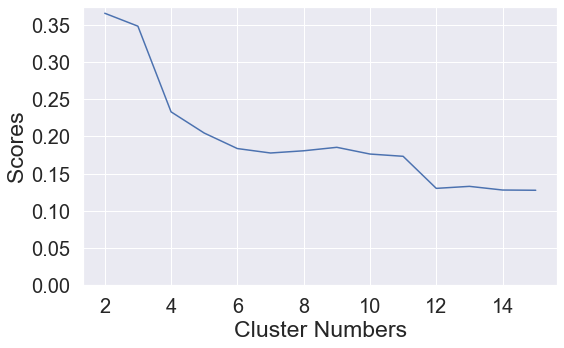

In [30]:
sns.set(rc={"figure.figsize":(20, 9)})

#l1 elasticnet l2 performance
silhouete_scores_Df = pd.DataFrame({'Cluster Numbers':[n for n in range(2,16)],'Scores':scores})

sns.set(rc={"figure.figsize":(8, 5)})
sns.lineplot(data = silhouete_scores_Df, x = 'Cluster Numbers', y = 'Scores')
plt.xlabel('Cluster Numbers', fontsize=23)
plt.ylabel('Scores', fontsize=23)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 0.375)

plt.tight_layout()
plt.savefig('Scores for diferent Cluster Numbers')
plt.show()

In [18]:
# Get best number of clusters

scores_clustrs_list = list(zip(range(2,16), scores))

t_before = scores_clustrs_list[0][0]
s_before = scores_clustrs_list[0][1]

for t, s in scores_clustrs_list:
    if s > s_before:
        t_before = t
        s_before = s

print(t_before)
print(s_before)

# k is the best number of clusters
k = t_before

2
0.16587546985203533


In [19]:
# Although the best was 2 according to the silhouette score, 5 doesn't have a very different silhouette score and permits to get
# more cluster and more populations to analyse

k = 5
print(scores[3])

0.11216390086363023


In [20]:
# Separate the data to each cluster

from scipy.cluster.hierarchy import fcluster

groups = fcluster(Z, t=k, criterion='maxclust')

print(groups)

[4 5 5 ... 5 4 5]


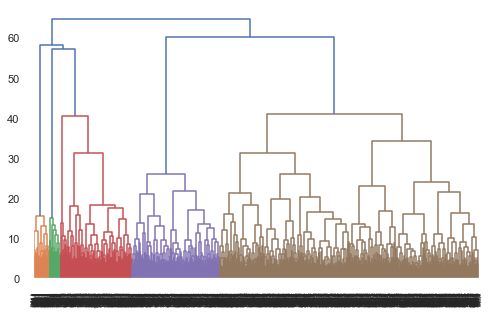

In [21]:
n= len(Data)

# calculate labels
labels=list('' for i in range(n))
for i in range(n):
    labels[i]=str(i)+ ',' + str(groups[i])

# calculate color threshold
ct=Z[-(k-1),2]  

#plot
P =sch.dendrogram(Z,labels=labels,color_threshold=ct)

#plt.savefig('dendrogram clusters.png', format='png', bbox_inches='tight')

plt.show()

In [ ]:
# Observations per cluster

d = {}
for n in groups:
    if n not in d:
        d[n] = 1
    else:
        d[n] = d[n] + 1

d

{4: 358, 5: 1062, 3: 294, 1: 69, 2: 45}

In [ ]:
Data_cluster_1 = pd.DataFrame(columns=Data.columns)
Data_class_1 = []
Data_cluster_2 = pd.DataFrame(columns=Data.columns)
Data_class_2 = []
Data_cluster_3 = pd.DataFrame(columns=Data.columns)
Data_class_3 = []
Data_cluster_4 = pd.DataFrame(columns=Data.columns)
Data_class_4 = []
Data_cluster_5 = pd.DataFrame(columns=Data.columns)
Data_class_5 = []
# ... can add more if needed

id = 0

for n in groups:
    if n == 1:
        Data_cluster_1.loc[len(Data_cluster_1)] = Data.loc[id].tolist()
        Data_class_1.append(Class[id])
        id = id + 1
    elif n == 2:
        Data_cluster_2.loc[len(Data_cluster_2)] = Data.loc[id].tolist()
        Data_class_2.append(Class[id])
        id = id + 1
    elif n == 3:
        Data_cluster_3.loc[len(Data_cluster_3)] = Data.loc[id].tolist()
        Data_class_3.append(Class[id])
        id = id + 1
    elif n == 4:
        Data_cluster_4.loc[len(Data_cluster_4)] = Data.loc[id].tolist()
        Data_class_4.append(Class[id])
        id = id + 1
    elif n == 5:
        Data_cluster_5.loc[len(Data_cluster_5)] = Data.loc[id].tolist()
        Data_class_5.append(Class[id])
        id = id + 1
    # ... can add more if needed

In [ ]:
Data_clusters_list = ['Data_cluster_' + str(n) for n in range(1,k+1)]

In [ ]:
# proportion of class 1 versus all variebles

Data_clusters_list = [Data_cluster_1, Data_cluster_2, Data_cluster_3, Data_cluster_4, Data_cluster_5]
Data_class_list = [[Data_class_1, 1], [Data_class_2, 2], [Data_class_3, 3], [Data_class_4, 4], [Data_class_5, 5]]
No_Model_List = []
# ... can add more if needed

for n in range(0,k):

    cluster_classes = Data_class_list[n][0]
    cluster_number = Data_class_list[n][1]

    print('cluster', cluster_number)

    total1 = 0
    for nclass in cluster_classes:
        if nclass == 1:
            total1 += 1

    # If the proportion of mortality of a cluster is very very small, it's not worth it to turn it into a model
    # If less than 5% is mortality, every test observation that will be assigned to that cluster will be considered as 
    # Non Mortality
    if total1/len(cluster_classes)<=0.05:
        print('No Model for this cluster')
        No_Model_List.append(1)
    else:
        No_Model_List.append(0)

    print(total1/len(cluster_classes))
    print()

cluster 1
0.08695652173913043

cluster 2
0.35555555555555557

cluster 3
0.3843537414965986

cluster 4
0.1005586592178771

cluster 5
0.13653483992467044



In [ ]:
No_Model_List

[0, 0, 0, 0, 0]

In [ ]:
np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/No_Model_List_24h-48h_Mortality_SS_C.npy', No_Model_List)

if len(Data_class_1) > 1:
    Data_cluster_1.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_1_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_1_class_24h-48h_Mortality_SS_C.npy', Data_class_1)

if len(Data_class_2) > 1:
    Data_cluster_2.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_2_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_2_class_24h-48h_Mortality_SS_C.npy', Data_class_2)

if len(Data_class_3) > 1:
    Data_cluster_3.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_3_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_3_class_24h-48h_Mortality_SS_C.npy', Data_class_3)

if len(Data_class_4) > 1:
    Data_cluster_4.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_4_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_4_class_24h-48h_Mortality_SS_C.npy', Data_class_4)

if len(Data_class_5) > 1:
    Data_cluster_5.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_5_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_5_class_24h-48h_Mortality_SS_C.npy', Data_class_5)

# ... can add more if needed

# ADASYN

Applying Adasyn to each cluster

In [ ]:
ada = ADASYN(sampling_strategy='auto', random_state=0, n_neighbors = 5)
smote = SMOTE()

# This to save to csv and np the data and classes
cluster_classes_oversample = []
cluster_data_oversample = []

for n in range(0,k):


    cluster_classes = Data_class_list[n][0]
    cluster_number = Data_class_list[n][1]
    cluster_data = Data_clusters_list[n]

    print('cluster', cluster_number)

    print(Counter(cluster_classes))
    if No_Model_List[n] == 1:
        print('No Model, No OverSampling')
        print()

        cluster_data_oversample.append(cluster_data)
        cluster_classes_oversample.append(cluster_classes)

    else:
        cluster_data, cluster_classes = ada.fit_resample(cluster_data, cluster_classes)
        #X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

        print(Counter(cluster_classes))
        print('New size:', len(cluster_classes))
        print()

        cluster_data_oversample.append(cluster_data)
        cluster_classes_oversample.append(cluster_classes)


cluster 1
Counter({0.0: 63, 1.0: 6})
Counter({0.0: 63, 1.0: 63})
New size: 126

cluster 2
Counter({0.0: 29, 1.0: 16})
Counter({1.0: 30, 0.0: 29})
New size: 59

cluster 3
Counter({0.0: 181, 1.0: 113})
Counter({0.0: 181, 1.0: 179})
New size: 360

cluster 4
Counter({0.0: 322, 1.0: 36})
Counter({0.0: 322, 1.0: 312})
New size: 634

cluster 5
Counter({0.0: 917, 1.0: 145})
Counter({1.0: 931, 0.0: 917})
New size: 1848



In [ ]:
# Still needs to change

if len(cluster_classes_oversample[0]) > 1:
    cluster_data_oversample[0].to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_1_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_1_class_24h-48h_Mortality_SS_C.npy', cluster_classes_oversample[0])

if len(cluster_classes_oversample[1]) > 1:
    cluster_data_oversample[1].to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_2_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_2_class_24h-48h_Mortality_SS_C.npy', cluster_classes_oversample[1])

if len(cluster_classes_oversample[2]) > 1:
    cluster_data_oversample[2].to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_3_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_3_class_24h-48h_Mortality_SS_C.npy', cluster_classes_oversample[2])

if len(cluster_classes_oversample[3]) > 1:
    cluster_data_oversample[3].to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_4_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_4_class_24h-48h_Mortality_SS_C.npy', cluster_classes_oversample[3])

if len(cluster_classes_oversample[4]) > 1:
    cluster_data_oversample[4].to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_5_24h-48h_Mortality_SS_C.csv', index=False)
    np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_5_class_24h-48h_Mortality_SS_C.npy', cluster_classes_oversample[4])

# ... can add more if needed

# Dato for proof of concept (More seperable clusters)

Cluster 1 and 2 will be the same as before, because they have less than 75 observations. Also for test, they will be the same observations, as they have less than 50 closest test observations

Here, we will also try to mantain a similar ratio of 0s and 1s from the original clusters

In [ ]:
# For cluster 3 without oversample

centroid = Data_cluster_3.mean().tolist()

# calculate distance between test and centroid

distances_all = []

for index, row in Data_cluster_3.iterrows():

    row = row.tolist()


    eu_dis = np.linalg.norm(np.array(row)-np.array(centroid))

    distances_all.append(eu_dis)

distances_all = np.array(distances_all)

# the first k elements will be the k-smallest elements in idx
idx = np.argpartition(distances_all, 75)

idx = idx[:75]

New_cluster_for_Separation_X = Data_cluster_3.iloc[idx]
New_cluster_for_Separation_Y = np.array(Data_class_3)[idx]

print(Counter(New_cluster_for_Separation_Y))

Counter({0.0: 45, 1.0: 30})


This one as a somewhat good proportion of 0 and 1

In [ ]:
New_3_X_Data = New_cluster_for_Separation_X.copy()
New_3_Y_Data = New_cluster_for_Separation_Y.copy()

New_cluster_for_Separation_X.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_DATA_3.csv', index=False)
np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_CLASS_3.npy', New_cluster_for_Separation_Y)

Original cluster 4 proportion was 10%, I need at least 7 1s

In [ ]:
# For cluster 4 without oversample

centroid = Data_cluster_4.mean().tolist()

# calculate distance between test and centroid

distances_all = []

for index, row in Data_cluster_4.iterrows():

    row = row.tolist()


    eu_dis = np.linalg.norm(np.array(row)-np.array(centroid))

    distances_all.append(eu_dis)

distances_all = np.array(distances_all)

# the first k elements will be the k-smallest elements in idx
idx = np.argpartition(distances_all, 69)

idx = idx[:69]

New_cluster_for_Separation_X = Data_cluster_4.iloc[idx]
New_cluster_for_Separation_Y = np.array(Data_class_4)[idx]

print(Counter(New_cluster_for_Separation_Y))



#Now to get more 1s
Data_Y_index_just_mortality = [i for i in range(len(Data_class_4)) if Data_class_4[i] == 1]
Data_X_just_mortality = Data_cluster_4.iloc[Data_Y_index_just_mortality]

distances_1_with_idx = []
distances_1 = []

for index, row in Data_X_just_mortality.iterrows():

    row = row.tolist()

    eu_dis = np.linalg.norm(np.array(row)-np.array(centroid))

    distances_1_with_idx.append((eu_dis,index))
    distances_1.append((eu_dis))

distances_1 = np.array(distances_1)
distances_1_with_idx = np.array(distances_1_with_idx)

# the first k elements will be the k-smallest elements in idx
idx_1 = np.argpartition(distances_1, 10)

idx_1 = idx_1[:10]

distances_1_with_idx = distances_1_with_idx[idx_1]

# Now add the rows with one that werent before in the data
for dis, index in distances_1_with_idx:
    index = int(index)
    if index not in idx:
        new_row = Data_X_just_mortality.loc[index]

        New_cluster_for_Separation_X =New_cluster_for_Separation_X.append(new_row)
        New_cluster_for_Separation_Y = np.append(New_cluster_for_Separation_Y, 1.0)

print(Counter(New_cluster_for_Separation_Y))


Counter({0.0: 65, 1.0: 4})
Counter({0.0: 65, 1.0: 10})


In [ ]:
New_4_X_Data = New_cluster_for_Separation_X.copy()
New_4_Y_Data = New_cluster_for_Separation_Y.copy()

New_cluster_for_Separation_X.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_DATA_4.csv', index=False)
np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_CLASS_4.npy', New_cluster_for_Separation_Y)

Original cluster 5 proportion was 14%, I need at least 11 1s

In [ ]:
# For cluster 4 without oversample

centroid = Data_cluster_5.mean().tolist()

# calculate distance between test and centroid

distances_all = []

for index, row in Data_cluster_5.iterrows():

    row = row.tolist()


    eu_dis = np.linalg.norm(np.array(row)-np.array(centroid))

    distances_all.append(eu_dis)

distances_all = np.array(distances_all)

# the first k elements will be the k-smallest elements in idx
idx = np.argpartition(distances_all, 68)

idx = idx[:68]

New_cluster_for_Separation_X = Data_cluster_5.iloc[idx]
New_cluster_for_Separation_Y = np.array(Data_class_5)[idx]

print(Counter(New_cluster_for_Separation_Y))



#Now to get more 1s
Data_Y_index_just_mortality = [i for i in range(len(Data_class_5)) if Data_class_5[i] == 1]
Data_X_just_mortality = Data_cluster_5.iloc[Data_Y_index_just_mortality]

distances_1_with_idx = []
distances_1 = []

for index, row in Data_X_just_mortality.iterrows():

    row = row.tolist()

    eu_dis = np.linalg.norm(np.array(row)-np.array(centroid))

    distances_1_with_idx.append((eu_dis,index))
    distances_1.append((eu_dis))

distances_1 = np.array(distances_1)
distances_1_with_idx = np.array(distances_1_with_idx)

# the first k elements will be the k-smallest elements in idx
idx_1 = np.argpartition(distances_1, 12)

idx_1 = idx_1[:12]

distances_1_with_idx = distances_1_with_idx[idx_1]

# Now add the rows with one that werent before in the data
for dis, index in distances_1_with_idx:
    index = int(index)
    if index not in idx:
        new_row = Data_X_just_mortality.loc[index]

        New_cluster_for_Separation_X =New_cluster_for_Separation_X.append(new_row)
        New_cluster_for_Separation_Y = np.append(New_cluster_for_Separation_Y, 1.0)

print(Counter(New_cluster_for_Separation_Y))


Counter({0.0: 63, 1.0: 5})
Counter({0.0: 63, 1.0: 12})


In [ ]:
New_5_X_Data = New_cluster_for_Separation_X.copy()
New_5_Y_Data = New_cluster_for_Separation_Y.copy()

New_cluster_for_Separation_X.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_DATA_5.csv', index=False)
np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_CLASS_5.npy', New_cluster_for_Separation_Y)

In [ ]:
# Size of each new cluster

print(len(Data_cluster_1))
print(len(Data_cluster_2))
print(len(New_3_X_Data))
print(len(New_4_X_Data))
print(len(New_5_X_Data))

Combined = pd.concat([Data_cluster_1, Data_cluster_2, New_3_X_Data, New_4_X_Data, New_5_X_Data])

69
45
75
75
75


In [ ]:
labels = [1 for n in range(0,len(Data_cluster_1))] + [2 for n in range(0,len(Data_cluster_2))] + [3 for n in range(0,len(New_3_X_Data))] + [4 for n in range(0,len(New_4_X_Data))] + [5 for n in range(0,len(New_5_X_Data))]
print(len(labels))

339


In [ ]:
# silhouette score of the new data

silhouette_score(Combined, labels)

0.20465711801187217